In [1]:
import os
import sys
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
import mne

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces, find_nearest_ind

from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib notebook

### Subjects

In [5]:
sub_dirs = {
    '521885': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521885\estim1_2020-07-09_14-23-49\recording1',
    '521886': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521886\estim1_2020-07-16_13-37-02\recording1',
    '521887': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse521887\estimfull_2020-07-30\experiment1\recordingfull',
    '543393': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543393\estim1_2020-08-20_13-24-53\experiment1\recording1',
    '543394': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543394\estim1_2020-08-27_14-32-00\experiment1\recording1',
    '543395': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543395\estim1_2020-09-03_13-19-42\experiment1\recording1',
    '543396': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse543396\estim_vis1_2020-09-18_12-04-46\experiment1\recording1',
    '546655': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse546655\estim_vis_2020-10-23_11-01-14\experiment1\recording1',
    '551400': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551400\estim_vis_2021-01-22_11-07-12\experiment1\recording1',
    '551399': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551399\estim_2021-01-28_13-59-09\experiment1\recording1',
    '551397': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\estim_vis_2021-02-11_10-45-23\experiment1\recording1',
    '569062': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569062\estim_vis_2021-02-18_11-17-51\experiment1\recording1',
    '569068': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569068\estim_vis_2021-03-04_10-51-38\experiment1\recording1',
    '569069': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569069\estim_vis2_2021-03-12_10-52-44\experiment1\recording1',
}

In [6]:
## Sweep ids for each brain state
brain_states = {
    '521885': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [], 'recovery_30-60min': []},
    '521886': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '521887': {'awake': [0, 1], 'anesthetized': [2, 3, 4], 'recovery_0-30min': [5, 6, 7], 'recovery_30-60min': []},
    '543393': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery_0-30min': [6, 7, 8], 'recovery_30-60min': []},
    '543394': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5], 'recovery_0-30min': [6, 7, 8], 'recovery_30-60min': []},
    '543395': {'awake': [0, 1, 2], 'anesthetized': [3, 4, 5, 6], 'recovery_0-30min': [7, 8, 9], 'recovery_30-60min': []},
    '543396': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '546655': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []}, # sweep 3 was incomplete
    '551400': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '551399': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '551397': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569062': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': []},
    '569068': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
    '569069': {'awake': [0], 'anesthetized': [1], 'recovery_0-30min': [2], 'recovery_30-60min': [3]},
}

In [17]:
## Stim amplitudes for the PCI calculation
PCI_stim_amp = {
    '521885': 50,
    '521886': 50,
    '521887': 20,
    '543393': 70,
    '543394': 50,
    '543395': 60,
    '543396': '80',
    '546655': '70',
    '551400': '50',
    '551399': 60,
    '551397': '30',
    '569062': '35',
    '569068': '20',
    '569069': '40',
}

### Load experiments

In [8]:
sub_exp = {}
for mousei, recdiri in sub_dirs.items():
    sub_exp[mousei] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)
    
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\EEG_analysis'

Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
Experiment type: electrical stimulation
SomnoSuite log file not found.
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation
Experiment type: electrical and sensory stimulation


### Load eeg data and gather stim-evoked traces, avg traces, and filtered traces?

In [9]:
## parameters ##
before_event = 1. # s, look at 1 s pre-stim
after_event = 1. # s, look at 1 s post-stim

apply_mask = True
apply_car = True

In [10]:
estim_traces = {}
sub_good_chs = {}
for mousei, expi in sub_exp.items():
    print(mousei)
    start = time.time()
    # load stim log
    stim_log, good_chs = expi.qualitycheck_trials_chs()
    
    # load data
    datai, tsi = expi.load_eegdata()
    eegchs = np.arange(0, datai.shape[1])
    
    # mask estim artifact
    if apply_mask:
        mask_samples = int(0.002 * expi.ephys_params['EEG']['sample_rate'])
        for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
            val = find_nearest_ind(tsi, etime) - 2
            datai[val:val+mask_samples, :] = datai[val:val-mask_samples:-1, :]
    
    # get evoked traces
    estim_traces[mousei] = {}
    sub_good_chs[mousei] = good_chs
    
    for st_type in np.sort(stim_log.stim_type.unique()):
        estim_traces[mousei][st_type] = {}
        
        for parami in np.sort(stim_log.loc[stim_log.stim_type == st_type, 'parameter'].unique()):
            estim_traces[mousei][st_type][parami] = {}
            
            param_mask = (stim_log.stim_type == st_type) & (stim_log.parameter == parami)
            for sweepi in np.sort(stim_log.loc[param_mask, 'sweep'].unique()):
                events = get_stim_events(stim_log, st_type, parami, sweepi)
                if len(events) == 0:
                    continue
                event_traces, event_ts = get_evoked_traces(
                    datai,
                    tsi,
                    events,
                    before_event,
                    after_event,
                    expi.ephys_params['EEG']['sample_rate']
                )

                # apply common avg
                if apply_car:
                    event_traces = event_traces - np.mean(event_traces[:,good_chs[st_type][parami][sweepi],:], axis=1)[:,None,:]

                # apply lowpass filter
                filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')

                estim_traces[mousei][st_type][parami][sweepi] = [event_ts, signal.filtfilt(filtb, filta, event_traces, axis=0)]
                    
    del datai
    del tsi
    del stim_log

    end = time.time()
    print('Time to analyze: {:.2f} s'.format(end - start))

521885
Time to analyze: 10.18 s
521886
Time to analyze: 23.27 s
521887
Time to analyze: 21.71 s
543393
Time to analyze: 23.67 s
543394
Time to analyze: 24.36 s
543395
Time to analyze: 20.29 s
543396
Time to analyze: 15.61 s
546655
Time to analyze: 35.16 s
551400
Time to analyze: 47.19 s
551399
Time to analyze: 38.03 s
551397
Time to analyze: 48.06 s
569062
Time to analyze: 39.56 s
569068
Time to analyze: 48.76 s
569069
Time to analyze: 48.67 s


### Want to analyze duration of EEG response

<IPython.core.display.Javascript object>


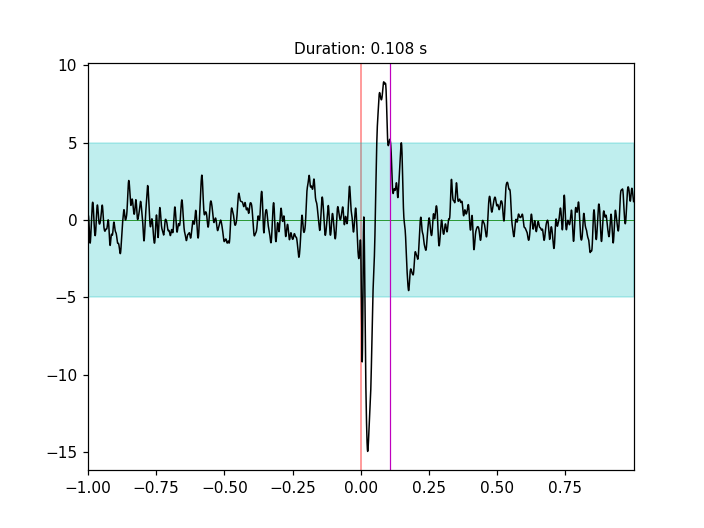

Text(0.5, 1.0, 'Duration: 0.108 s')

In [67]:
subject = '551397'
stim = 'biphasic'
param = '30'
sweep = 3
cha = 4
z_thresh = 5

## this is the data ##
timex = estim_traces[subject][stim][param][sweep][0]
trace = np.mean(estim_traces[subject][stim][param][sweep][1][:,cha,:], axis=1)xu

## find z-score of cha ##
z_cha = (trace - np.mean(trace[timex < -0.005])) / np.std(trace[timex < -0.005])
if (np.abs(z_cha) > z_thresh).any():
    dur_cha = timex[np.nonzero(np.abs(z_cha) > z_thresh)[0][-1]]
else:
    dur_cha = np.nan

fig, ax = plt.subplots()
ax.axhline(0, color='g', linewidth=0.5)
ax.plot(timex, z_cha, color='k', linewidth=1)
ax.axvspan(-.001, .001, color='r', alpha=0.5)
ax.axhspan(-z_thresh, z_thresh, color='c', alpha=0.25)
ax.axvline(dur_cha, color='m', linewidth=0.8)
ax.set_xlim([timex[0], timex[-1]])
ax.set_title('Duration: {:.3f} s'.format(dur_cha))

In [28]:
## Now do all GOOD electrodes ##
traces = np.mean(estim_traces[subject][stim][param][sweep][1], axis=2)
z_traces = (traces - np.mean(traces[timex < -0.005,:], axis=0)) / np.std(traces[timex < -0.005,:], axis=0)
dur_chs = []
for chi in sub_good_chs[subject][stim][param][sweep]:
    zinds = np.nonzero(np.abs(z_traces[:,chi]) > z_thresh)[0]
    if (zinds.size > 0 and timex[zinds[-1]] > 0):
        dur_chs.append(timex[zinds[-1]])
dur_chs = np.array(dur_chs)
print(dur_chs.shape)
print(dur_chs.min())
print(dur_chs.max())
print(dur_chs.mean())
print(np.median(dur_chs))

(28,)
0.01
0.2704
0.0828
0.056


In [68]:
subject = '551397'
comp_sweeps = [0,1,2,3]
comp_zthr = [2,3,4,5]

zthr_dur_dfs = {}
for z_thr in comp_zthr:
    ch_list = []
    amp_list = []
    sweep_list = []
    dur_list = []
    for ampi in estim_traces[subject]['biphasic'].keys():
        for sweepi in comp_sweeps:
            timex = estim_traces[subject]['biphasic'][ampi][sweepi][0]
            traces = np.mean(estim_traces[subject]['biphasic'][ampi][sweepi][1], axis=2)
            z_traces = (traces - np.mean(traces[timex < -0.005,:], axis=0)) / np.std(traces[timex < -0.005,:], axis=0)
            for chi in sub_good_chs[subject]['biphasic'][ampi][sweepi]:
                zinds = np.nonzero(np.abs(z_traces[:,chi]) > z_thr)[0]
                if ((zinds.size > 0) and (timex[zinds[-1]] > 0)): 
                    ch_list.append(chi)
                    amp_list.append(ampi)
                    sweep_list.append(sweepi)
                    dur_list.append(timex[zinds[-1]])
    zthr_dur_dfs[z_thr] = pd.DataFrame({
        'ch': ch_list,
        'amp': amp_list,
        'sweep': sweep_list,
        'duration': dur_list
    })

<IPython.core.display.Javascript object>


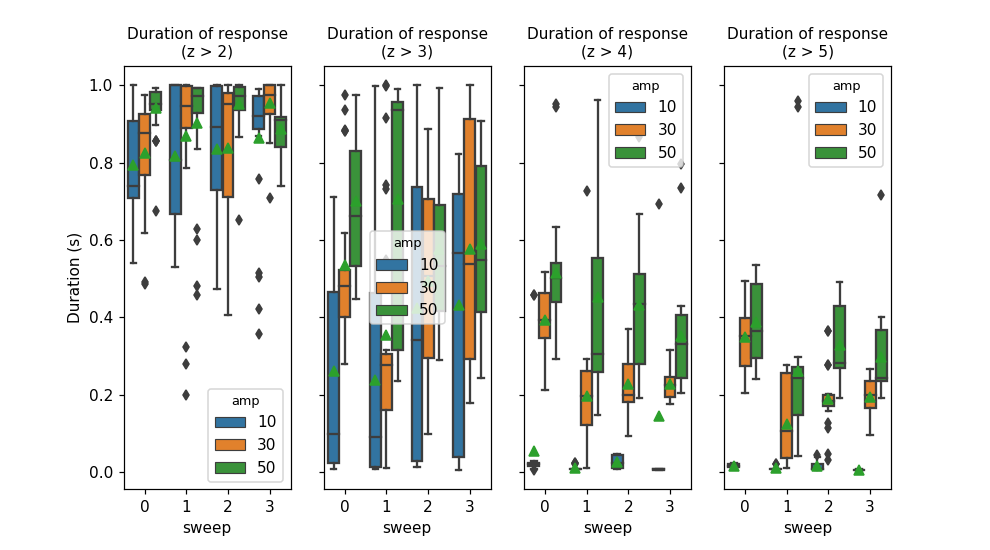

Text(0, 0.5, 'Duration (s)')

In [69]:
fig, axs = plt.subplots(1, len(comp_zthr), figsize=(9,5), sharey=True)

for ax, (z_thr, df_dur) in zip(axs, zthr_dur_dfs.items()):
    bxplt = sns.boxplot(x='sweep', y='duration', hue='amp', data=df_dur, ax=ax, showmeans=True)
    bxplt.set_ylabel('')
    bxplt.set_title('Duration of response\n(z > {:d})'.format(z_thr))
    
axs[0].set_ylabel('Duration (s)')

The z-score threshold of z=5 appears to be good. It shows quite low durations, but at least shows consistency and less outliers due to random fluctuations of the spontaneous voltage. Still, using the median duration value seems the most appropriate and often matches the mean value.

In [29]:
## Collect data for multi subjects ##
z_threshold = 5
subjects = [
    '521885', '521886', '521887', '543393', '543394', '543396', '546655',
    '551399', '551397', '569062', '569068', '569069'
]
# all: '521885', '521886', '521887', '543393', '543394', '543395', '543396', '546655',
#'551400', '551399', '551397', '569062', '569068', '569069'
states = ['awake', 'anesthetized']

sub_list = []
ch_list = []
state_list = []
dur_list = []
for subject in subjects:
    ampi = PCI_stim_amp[subject]
#     for statei, sweeps in brain_states[subject].items():
    for statei in states:
        sweeps = brain_states[subject][statei]
        if len(sweeps) == 0:
            continue
        traces = []
        good_chs = []
        for sweepi in sweeps:
            if sweepi not in estim_traces[subject]['biphasic'][ampi].keys():
                continue
            traces.append(estim_traces[subject]['biphasic'][ampi][sweepi][1])
            good_chs.append(sub_good_chs[subject]['biphasic'][ampi][sweepi])
        all_traces = np.mean(np.concatenate(traces, axis=2), axis=2)
        timex = estim_traces[subject]['biphasic'][ampi][sweepi][0]
        z_traces = (
            (all_traces - np.mean(all_traces[timex < -0.005,:], axis=0)) / np.std(all_traces[timex < -0.005,:], axis=0)
        )
        GOOD_CHS = np.array(list(set.intersection(*map(set, good_chs))))
        for chi in GOOD_CHS:
            zinds = np.nonzero(np.abs(z_traces[:,chi]) > z_threshold)[0]
            if ((zinds.size > 0) and (timex[zinds[-1]] > 0)): 
                ch_list.append(chi)
                sub_list.append(subject)
                state_list.append(statei)
                dur_list.append(timex[zinds[-1]])
                    
df_duration = pd.DataFrame({
    'ch': ch_list,
    'mouse': sub_list,
    'state': state_list,
    'duration': dur_list
})

<IPython.core.display.Javascript object>


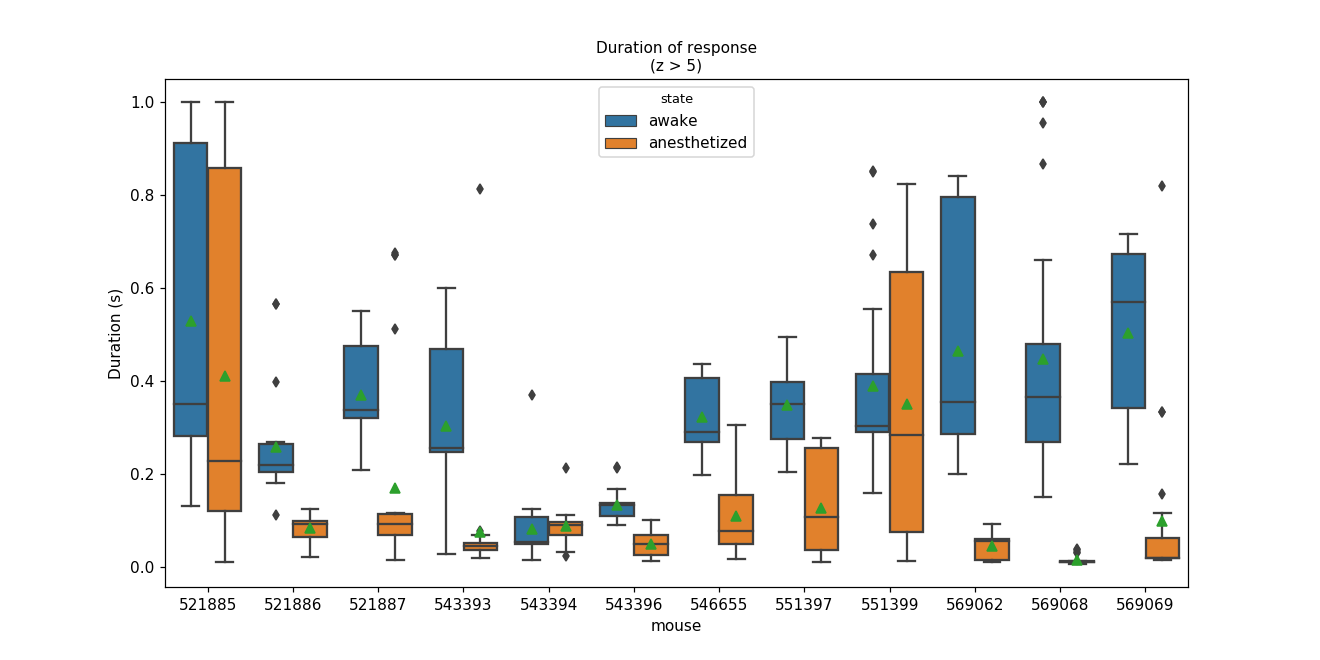

In [31]:
fig, ax = plt.subplots(figsize=(12,6))

bxplt = sns.boxplot(x='mouse', y='duration', hue='state', data=df_duration, ax=ax, showmeans=True)

bxplt.set_title('Duration of response\n(z > {:d})'.format(z_threshold))
bxplt.set_ylabel('Duration (s)')

## Save ##
figname = 'EEG_response_duration_awake_iso_goodmice.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

### Calculate PCIst, match trial numbers of states

In [11]:
states = ['awake', 'anesthetized']

PCI_params = {
    'baseline_window': (-0.5, -0.005), # s before stim for baseline, my default: (-0.5, -0.001)
    'response_window': (0.005, 0.5), # s after stim for response, my default: (0.001, 0.5)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

In [12]:
PCIst_value = {}
num_PCs = {}
num_trials = {}
for subject in estim_traces.keys():
    print(subject)
    PCIst_value[subject] = {}
    num_PCs[subject] = {}
    num_trials[subject] = {}
    
    start = time.time()
    for statei in states:
        PCIst_value[subject][statei] = {}
        num_PCs[subject][statei] = {}
        num_trials[subject][statei] = {}
        
        for ampi, datadict in estim_traces[subject][statei].items():
            ## Calculate PCIst with full return ##
            full_PCI_output = calc_PCIst(
                np.mean(datadict[1][:, sub_good_chs[subject][statei][ampi], :], axis=2).T,
                datadict[0],
                full_return=True,
                **PCI_params
            )
            
            PCIst_value[subject][statei][ampi] = full_PCI_output['PCI']
            num_PCs[subject][statei][ampi] = full_PCI_output['n_dims']
            num_trials[subject][statei][ampi] = datadict[1].shape[2]
#             print('{:s} PCI = {:.3f}'.format(statei, full_PCI_output['PCI']))

    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
#     print('')

521885
Time: 101.40 s
521886
Time: 78.42 s
521887
Time: 31.54 s
543393
Time: 31.37 s
543394
Time: 36.26 s
543396
Time: 30.85 s
546655
Time: 116.77 s
551399
Time: 101.34 s
551397
Time: 86.45 s
569062
Time: 101.30 s
569068
No components --> PCIst=0
Time: 73.04 s


### Compute EEG component magnitude

In [13]:
aucwin = [0.005, 0.5] # whole [0.005, 0.8], early [0.005, 0.1], sec comp [0.1, 0.3] [0.1, 0.2]
# CK asked to compare [0.005, 0.15] to [0.15, 0.25]

EEGmag = {}
for subject in estim_traces.keys():
    print(subject)
    EEGmag[subject] = {}
    
    start = time.time()
    for statei in states:
        EEGmag[subject][statei] = {}
        
        for ampi, datadict in estim_traces[subject][statei].items():
            timex = datadict[0]
            trace_data = np.mean(datadict[1][:, sub_good_chs[subject][statei][ampi], :], axis=2)
            
            ## Find auc values in baseline ##
            preinds = np.nonzero((timex >= -aucwin[1]) & (timex <= -aucwin[0]))[0]
            baseline_auc = integrate.simps(np.abs(trace_data[preinds, :]), timex[preinds], axis=0, even='last')

            ## Find auc values in response ##
            postinds = np.nonzero((timex >= aucwin[0]) & (timex <= aucwin[1]))[0]
            response_auc = integrate.simps(np.abs(trace_data[postinds, :]), timex[postinds], axis=0, even='last')
            
            EEGmag[subject][statei][ampi] = np.median(response_auc - baseline_auc)

    end = time.time()
    print('Time: {:.2f} s'.format(end-start))

521885
Time: 0.30 s
521886
Time: 0.47 s
521887
Time: 0.37 s
543393
Time: 0.48 s
543394
Time: 0.41 s
543396
Time: 0.12 s
546655
Time: 0.60 s
551399
Time: 0.65 s
551397
Time: 0.66 s
569062
Time: 0.65 s
569068
Time: 0.68 s


#### Scatter plot of PCI vs EEG magnitude

<IPython.core.display.Javascript object>


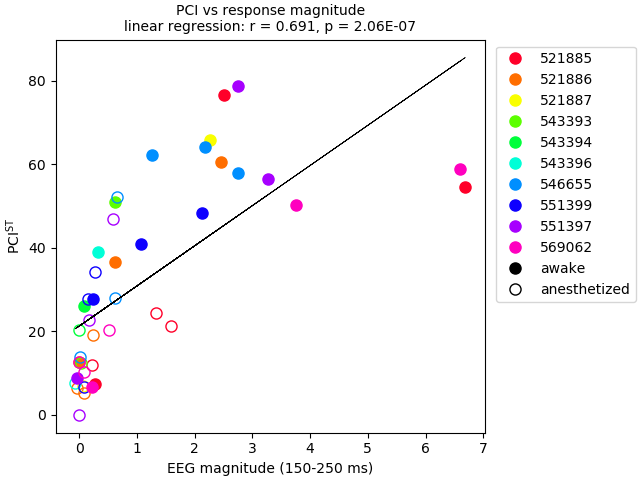

In [30]:
# make different colors for different mice
# sublist = ['521885', '521886', '521887', '543393', '543394', '543396', '546655', '551399', '551397']
colormap = plt.cm.gist_rainbow # gist_ncar gist_rainbow
subcolors = [colormap(i) for i in np.linspace(0, 1, len(PCIst_value.keys()))]
# subcolors = [colormap(i) for i in np.linspace(0, 1, len(sublist))]

fig, ax = plt.subplots(constrained_layout=True)
legend_entries = []
xvals = []
yvals = []
for subi, subject in enumerate(PCIst_value.keys()):
# for subi, subject in enumerate(sublist):
    legend_entries.append(
        Line2D([0], [0], color='none', marker='o',
               markerfacecolor=subcolors[subi],
               markeredgecolor=subcolors[subi],
               markersize=8, label=subject)
    )
    for statei in states:
        for ampi in PCIst_value[subject][statei].keys():
            if statei == 'awake':
                filled_marker_style = {
                    'marker': 'o',
                    'markersize': 8,
                    'fillstyle': 'full',
                    'markeredgecolor': subcolors[subi],
                    'markerfacecolor': subcolors[subi],
                }
            else:
                filled_marker_style = {
                    'marker': 'o',
                    'markersize': 8,
                    'fillstyle': 'none',
                    'markeredgecolor': subcolors[subi],
                }
            ax.plot(
                EEGmag[subject][statei][ampi],
                PCIst_value[subject][statei][ampi],
                **filled_marker_style
            )
            xvals.append(EEGmag[subject][statei][ampi])
            yvals.append(PCIst_value[subject][statei][ampi])

## fit a line ##
xvals = np.array(xvals)
yvals = np.array(yvals)
res = stats.linregress(xvals, yvals)
ax.plot(xvals, res.intercept + res.slope*xvals, 'k', linewidth=0.5) 

legend_entries.append(
    Line2D([0], [0], color='none', marker='o',
           markerfacecolor='k',
           markeredgecolor='k',
           markersize=8, label='awake')
)
legend_entries.append(
    Line2D([0], [0], color='none', marker='o',
           markerfacecolor='none',
           markeredgecolor='k',
           markersize=8, label='anesthetized'),
)
ax.legend(handles=legend_entries, bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel('EEG magnitude ({:d}-{:d} ms)'.format(int(aucwin[0]*1000), int(aucwin[1]*1000)))
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('PCI vs response magnitude\nlinear regression: r = {:.3f}, p = {:.2E}'.format(res.rvalue, res.pvalue))

## Save ##
figname = 'PCIvsEEGmag_auc{:d}-{:d}ms.png'.format(int(aucwin[0]*1000), int(aucwin[1]*1000))
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


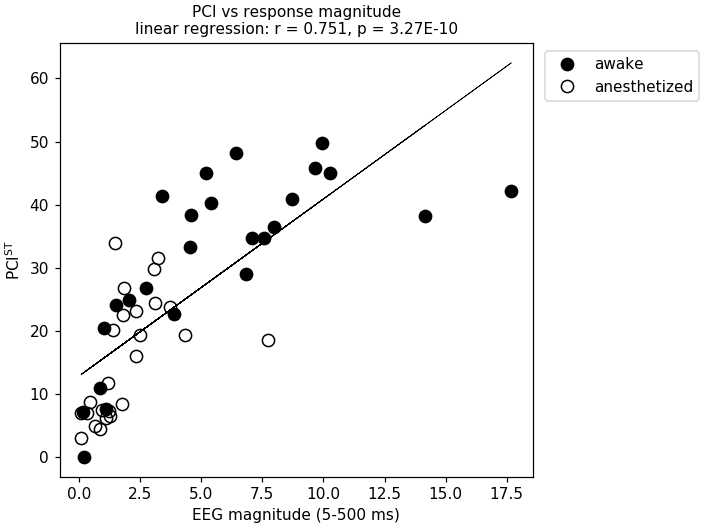

In [15]:
# same colors for different mice, different colors for two states
# sublist = ['521885', '521886', '521887', '543393', '543394', '543396', '546655', '551399', '551397']

fig, ax = plt.subplots(constrained_layout=True)
legend_entries = []
xvals = []
yvals = []
for subi, subject in enumerate(PCIst_value.keys()):
# for subi, subject in enumerate(sublist):
    for statei in states:
        for ampi in PCIst_value[subject][statei].keys():
            if statei == 'awake':
                filled_marker_style = {
                    'marker': 'o',
                    'markersize': 8,
                    'fillstyle': 'full',
                    'markeredgecolor': 'k',
                    'markerfacecolor': 'k',
                }
            else:
                filled_marker_style = {
                    'marker': 'o',
                    'markersize': 8,
                    'fillstyle': 'none',
                    'markeredgecolor': 'k',
                }
            ax.plot(
                EEGmag[subject][statei][ampi],
                PCIst_value[subject][statei][ampi],
                **filled_marker_style
            )
            xvals.append(EEGmag[subject][statei][ampi])
            yvals.append(PCIst_value[subject][statei][ampi])

## fit a line ##
xvals = np.array(xvals)
yvals = np.array(yvals)
res = stats.linregress(xvals, yvals)
ax.plot(xvals, res.intercept + res.slope*xvals, 'k', linewidth=0.5) 

legend_entries.append(
    Line2D([0], [0], color='none', marker='o',
           markerfacecolor='k',
           markeredgecolor='k',
           markersize=8, label='awake')
)
legend_entries.append(
    Line2D([0], [0], color='none', marker='o',
           markerfacecolor='none',
           markeredgecolor='k',
           markersize=8, label='anesthetized'),
)
ax.legend(handles=legend_entries, bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel('EEG magnitude ({:d}-{:d} ms)'.format(int(aucwin[0]*1000), int(aucwin[1]*1000)))
ax.set_ylabel('$\mathregular{PCI^{ST}}$')
ax.set_title('PCI vs response magnitude\nlinear regression: r = {:.3f}, p = {:.2E}'.format(res.rvalue, res.pvalue))

## Save ##
figname = 'PCIvsEEGmag_auc{:d}-{:d}ms_statecolors.png'.format(int(aucwin[0]*1000), int(aucwin[1]*1000))
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

#### Demonstrate EEG magnitude analysis

<IPython.core.display.Javascript object>


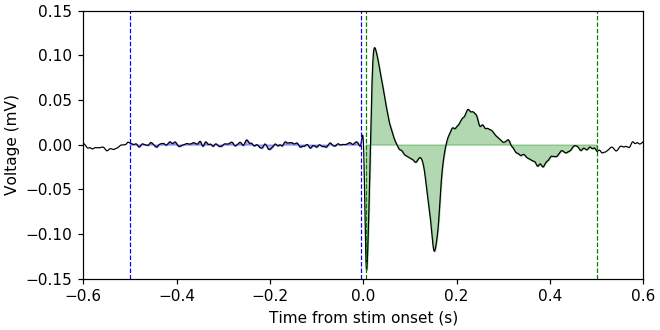

In [33]:
subject = '551397'
statei = 'awake'
parami = '30'
cha = 9

prex = .6 # ms before stim to plot
postx = .6 # ms after stim to plot
ylimit = 0.15 # mV

timex = estim_traces[subject][statei][parami][0]
plottraces = np.mean(estim_traces[subject][statei][parami][1], axis=2)/1000
plot_inds = np.nonzero((timex >= -prex) & (timex <= postx))[0]

fig, ax = plt.subplots(figsize=(6,3), constrained_layout=True)
ax.plot(timex[plot_inds], plottraces[plot_inds,cha], color='k', linewidth=0.8)
# ax.axvspan(-.001, .001, color='r', alpha=0.5)
## fill between ##
binds = np.nonzero((timex >= -0.5) & (timex <= -0.005))[0]
ax.fill_between(timex[binds], plottraces[binds,cha], color='b', alpha=0.3)
ax.axvline(-0.5, color='b', linestyle='--', linewidth=0.8)
ax.axvline(-0.005, color='b', linestyle='--', linewidth=0.8)
rinds = np.nonzero((timex >= 0.005) & (timex <= 0.5))[0]
ax.fill_between(timex[rinds], plottraces[rinds,cha], color='g', alpha=0.3)
ax.axvline(0.005, color='g', linestyle='--', linewidth=0.8)
ax.axvline(0.5, color='g', linestyle='--', linewidth=0.8)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
# ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

## Save ##
# fig.savefig(os.path.join(plotsdir, 'estim_comavgEEG_trialrectAUC_ch{:d}.png'.format(cha)), transparent=True)

### Comparison of first and second peak magnitude

In [26]:
window_comparison = [[0.005, 0.15], [0.15, 0.25]] # whole [0.005, 0.8], early [0.005, 0.1], sec comp [0.1, 0.3] [0.1, 0.2]
# CK asked to compare [0.005, 0.15] to [0.15, 0.25]

EEGmag = {}
for subject in estim_traces.keys():
    print(subject)
    EEGmag[subject] = {}
    
    for statei in states:
        EEGmag[subject][statei] = {}
        
        for ampi, datadict in estim_traces[subject][statei].items():
            timex = datadict[0]
            trace_data = np.mean(datadict[1][:, sub_good_chs[subject][statei][ampi], :], axis=2)
            
            med_auc = []
            for aucwin in window_comparison:
                ## Find auc values in baseline ##
                preinds = np.nonzero((timex >= -aucwin[1]) & (timex <= -aucwin[0]))[0]
                baseline_auc = integrate.simps(np.abs(trace_data[preinds, :]), timex[preinds], axis=0, even='last')

                ## Find auc values in response ##
                postinds = np.nonzero((timex >= aucwin[0]) & (timex <= aucwin[1]))[0]
                response_auc = integrate.simps(np.abs(trace_data[postinds, :]), timex[postinds], axis=0, even='last')
                med_auc.append(np.median(response_auc - baseline_auc))
            
            EEGmag[subject][statei][ampi] = med_auc

521885
521886
521887
543393
543394
543396
546655
551399
551397
569062


<IPython.core.display.Javascript object>


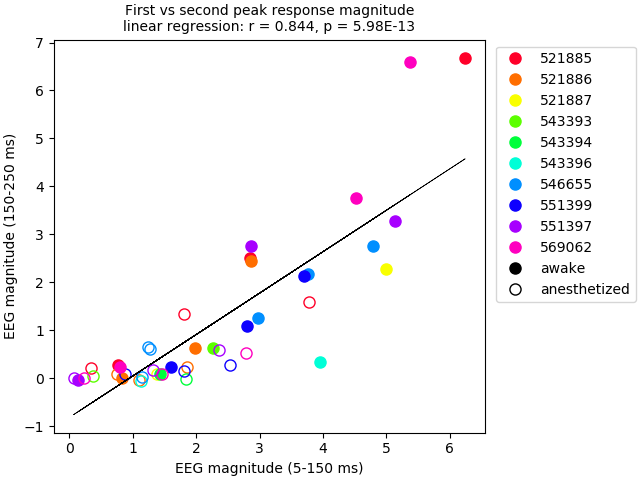

In [28]:
colormap = plt.cm.gist_rainbow # gist_ncar gist_rainbow
subcolors = [colormap(i) for i in np.linspace(0, 1, len(EEGmag.keys()))]
# subcolors = [colormap(i) for i in np.linspace(0, 1, len(sublist))]

fig, ax = plt.subplots(constrained_layout=True)
legend_entries = []
xvals = []
yvals = []
for subi, subject in enumerate(EEGmag.keys()):
# for subi, subject in enumerate(sublist):
    legend_entries.append(
        Line2D([0], [0], color='none', marker='o',
               markerfacecolor=subcolors[subi],
               markeredgecolor=subcolors[subi],
               markersize=8, label=subject)
    )
    for statei in states:
        for ampi in EEGmag[subject][statei].keys():
            if statei == 'awake':
                filled_marker_style = {
                    'marker': 'o',
                    'markersize': 8,
                    'fillstyle': 'full',
                    'markeredgecolor': subcolors[subi],
                    'markerfacecolor': subcolors[subi],
                }
            else:
                filled_marker_style = {
                    'marker': 'o',
                    'markersize': 8,
                    'fillstyle': 'none',
                    'markeredgecolor': subcolors[subi],
                }
            ax.plot(
                EEGmag[subject][statei][ampi][0],
                EEGmag[subject][statei][ampi][1],
                **filled_marker_style
            )
            xvals.append(EEGmag[subject][statei][ampi][0])
            yvals.append(EEGmag[subject][statei][ampi][1])

## fit a line ##
xvals = np.array(xvals)
yvals = np.array(yvals)
res = stats.linregress(xvals, yvals)
ax.plot(xvals, res.intercept + res.slope*xvals, 'k', linewidth=0.5) 

legend_entries.append(
    Line2D([0], [0], color='none', marker='o',
           markerfacecolor='k',
           markeredgecolor='k',
           markersize=8, label='awake')
)
legend_entries.append(
    Line2D([0], [0], color='none', marker='o',
           markerfacecolor='none',
           markeredgecolor='k',
           markersize=8, label='anesthetized'),
)
ax.legend(handles=legend_entries, bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_xlabel('EEG magnitude ({:d}-{:d} ms)'.format(int(window_comparison[0][0]*1000), int(window_comparison[0][1]*1000)))
ax.set_ylabel('EEG magnitude ({:d}-{:d} ms)'.format(int(window_comparison[1][0]*1000), int(window_comparison[1][1]*1000)))
ax.set_title('First vs second peak response magnitude\nlinear regression: r = {:.3f}, p = {:.2E}'.format(res.rvalue, res.pvalue))

## Save ##
figname = 'EEGmag_1stvs2ndpeak.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

### Within subject, compare high/low second component magnitude trials

In [34]:
mousei = '551397'
statei = 'awake'
ampi = '30'

secpk_win = [0.125, 0.245]
ntrials = 30

timex = estim_traces[mousei][statei][ampi][0]
alltrials = estim_traces[mousei][statei][ampi][1][:, sub_good_chs[mousei][statei][ampi], :]

## Find auc values in baseline ##
preinds = np.nonzero((timex >= -secpk_win[1]) & (timex <= -secpk_win[0]))[0]
baseline_auc = integrate.simps(np.abs(alltrials[preinds, :, :]), timex[preinds], axis=0, even='last')

## Find auc values in response ##
postinds = np.nonzero((timex >= secpk_win[0]) & (timex <= secpk_win[1]))[0]
response_auc = integrate.simps(np.abs(alltrials[postinds, :, :]), timex[postinds], axis=0, even='last')

sortedtrials = alltrials[:, :, np.squeeze(np.argsort(np.mean(response_auc - baseline_auc, axis=0)))]

PCI_lowsp = calc_PCIst(
    np.mean(sortedtrials[:, :, :ntrials], axis=2).T,
    timex,
    full_return=True,
    **PCI_params
)

PCI_highsp = calc_PCIst(
    np.mean(sortedtrials[:, :, -ntrials:], axis=2).T,
    timex,
    full_return=True,
    **PCI_params
)

<IPython.core.display.Javascript object>


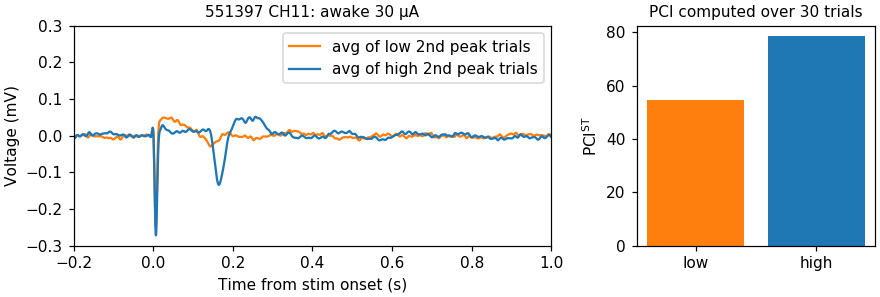

In [35]:
## plot it ##
cha = 11
plot_window = [-0.2, 1.0] # s before, after stim to plot
ylimit = 0.3 # mV
hiloc = ['tab:orange', 'tab:blue']

fig = plt.figure(figsize=(8,9*0.3), constrained_layout=True)
gs = fig.add_gridspec(ncols=2, nrows=1, left=0.1, right=0.98, wspace=0.3, width_ratios=[2,1])
pinds = np.nonzero((timex >= plot_window[0]) & (timex <= plot_window[1]))[0]

## plot high/low sec peak signals ##
traceax = fig.add_subplot(gs[0])
traceax.plot(timex[pinds], np.mean(sortedtrials[:, cha, :ntrials], axis=1)[pinds]/1000, color=hiloc[0], label='avg of low 2nd peak trials')
traceax.plot(timex[pinds], np.mean(sortedtrials[:, cha, -ntrials:], axis=1)[pinds]/1000, color=hiloc[1], label='avg of high 2nd peak trials')
traceax.set_xlim(plot_window)
traceax.set_ylim([-ylimit, ylimit])
traceax.legend()
traceax.set_xlabel('Time from stim onset (s)')
traceax.set_ylabel('Voltage (mV)')
traceax.set_title('{} CH{:d}: {} {} \u03BCA'.format(mousei, cha, statei, ampi))

## plot PCI from high/low sec peak signals ##
pciax = fig.add_subplot(gs[1])
barlabels = ['low', 'high']
PCIvals = [PCI_lowsp['PCI'], PCI_highsp['PCI']]
PCnums = [PCI_lowsp['n_dims'], PCI_highsp['n_dims']]
pciax.bar(barlabels, PCIvals, color=hiloc)
pciax.set_ylabel('$\mathregular{PCI^{ST}}$')
pciax.set_title('PCI computed over {:d} trials'.format(ntrials))

## Save ##
figname = '{}ch{:d}{}{}_hi-low2ndpeakcomp.png'.format(mousei, cha, statei, ampi)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


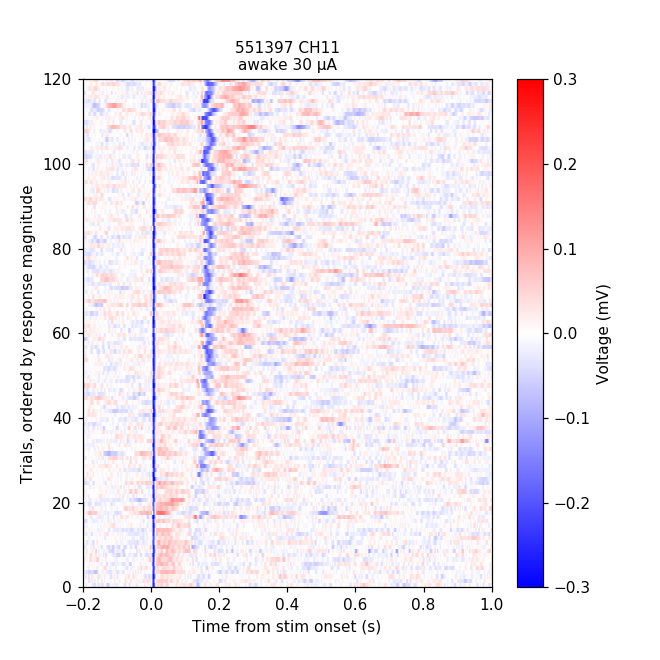

In [36]:
## Plot heat map ##
fig, ax = plt.subplots(figsize=(6,6))
trials_plot = ax.imshow(
    sortedtrials[pinds, cha, :].T/1000,
    cmap='bwr',
    aspect='auto',
    interpolation='none',
    origin='lower',
    vmin=-ylimit,
    vmax=ylimit,
    extent=[plot_window[0], plot_window[1], 0, sortedtrials.shape[2]],
)

ax.set_title('{} CH{:d}\n{} {} \u03BCA'.format(mousei, cha, statei, ampi))
ax.set_xlabel('Time from stim onset (s)')  
ax.set_ylabel('Trials, ordered by response magnitude')
             
cbar = plt.colorbar(trials_plot, ax=ax)
cbar.set_label('Voltage (mV)')

### SAVE ###
figname = '{}ch{:d}{}{}_rankedtrials.png'.format(mousei, cha, statei, ampi)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


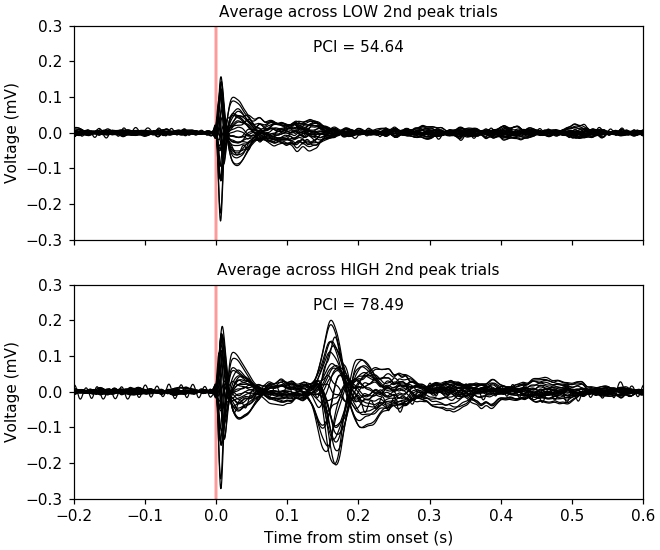

In [37]:
## plot butterfly plots of low and high ##
plot_window = [-0.2, 0.6] # s before, after stim to plot
ylimit = 0.3 # mV
hiloc = ['tab:orange', 'tab:blue']

fig, axs = plt.subplots(2, 1, figsize=(6,5), sharex=True, sharey=True, constrained_layout=True)
pinds = np.nonzero((timex >= plot_window[0]) & (timex <= plot_window[1]))[0]

## plot low sec peak signals ##
axs[0].plot(timex[pinds], np.mean(sortedtrials[:, :, :ntrials], axis=2)[pinds]/1000, color='k', linewidth=0.8)
axs[0].axvspan(-0.001, 0.001, color='r', alpha=0.25)
axs[0].set_xlim(plot_window)
axs[0].set_ylim([-ylimit, ylimit])
axs[0].set_ylabel('Voltage (mV)')
axs[0].set_title('Average across LOW 2nd peak trials')
axs[0].text(
    0.5, 0.9,
    ('PCI = {:.2f}'.format(PCI_lowsp['PCI'])),
    horizontalalignment='center',
    verticalalignment='center',
    transform = axs[0].transAxes
)

## plot high sec peak signals ##
axs[1].plot(timex[pinds], np.mean(sortedtrials[:, :, -ntrials:], axis=2)[pinds]/1000, color='k', linewidth=0.8)
axs[1].axvspan(-0.001, 0.001, color='r', alpha=0.25)
axs[1].set_xlabel('Time from stim onset (s)')
axs[1].set_ylabel('Voltage (mV)')
axs[1].set_title('Average across HIGH 2nd peak trials')
axs[1].text(
    0.5, 0.9,
    ('PCI = {:.2f}'.format(PCI_highsp['PCI'])),
    horizontalalignment='center',
    verticalalignment='center',
    transform = axs[1].transAxes
)

## Save ##
figname = '{}{}{}_hi-low2ndpeak_butterfly.png'.format(mousei, statei, ampi)
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

### Calculate PCI across all individuals in low and high 2nd peak trials

In [38]:
statei = 'awake'

PCIvalue = {}
nPCs = {}
dNST = {}
for subject in estim_traces.keys():
    print(subject)
    PCIvalue[subject] = {}
    nPCs[subject] = {}
    dNST[subject] = {}
    start = time.time()
    
    PCIamp = str(PCI_stim_amp[subject])
    timex = estim_traces[subject][statei][PCIamp][0]
    alltrials = estim_traces[subject][statei][PCIamp][1][:, sub_good_chs[subject][statei][PCIamp], :]

    ## Find auc values in baseline ##
    preinds = np.nonzero((timex >= -secpk_win[1]) & (timex <= -secpk_win[0]))[0]
    baseline_auc = integrate.simps(np.abs(alltrials[preinds, :, :]), timex[preinds], axis=0, even='last')

    ## Find auc values in response ##
    postinds = np.nonzero((timex >= secpk_win[0]) & (timex <= secpk_win[1]))[0]
    response_auc = integrate.simps(np.abs(alltrials[postinds, :, :]), timex[postinds], axis=0, even='last')

    sortedtrials = alltrials[:, :, np.squeeze(np.argsort(np.mean(response_auc - baseline_auc, axis=0)))]

    ## PCI in low trials ##
    PCIout = calc_PCIst(
        np.mean(sortedtrials[:, :, :ntrials], axis=2).T,
        timex,
        full_return=True,
        **PCI_params
    )
    PCIvalue[subject]['low'] = PCIout['PCI']
    nPCs[subject]['low'] = PCIout['n_dims']
    dNST[subject]['low'] = PCIout['dNST']

    PCIout = calc_PCIst(
        np.mean(sortedtrials[:, :, -ntrials:], axis=2).T,
        timex,
        full_return=True,
        **PCI_params
    )
    PCIvalue[subject]['high'] = PCIout['PCI']
    nPCs[subject]['high'] = PCIout['n_dims']
    dNST[subject]['high'] = PCIout['dNST']

    end = time.time()
    print('Time: {:.2f} s'.format(end-start))
#     print('')

521885
Time: 44.48 s
521886
Time: 26.18 s
521887
Time: 36.76 s
543393
Time: 30.97 s
543394
Time: 15.78 s
543396
Time: 29.91 s
546655
Time: 50.33 s
551399
Time: 40.53 s
551397
Time: 55.05 s
569062
Time: 49.96 s
569068
Time: 25.80 s


<IPython.core.display.Javascript object>


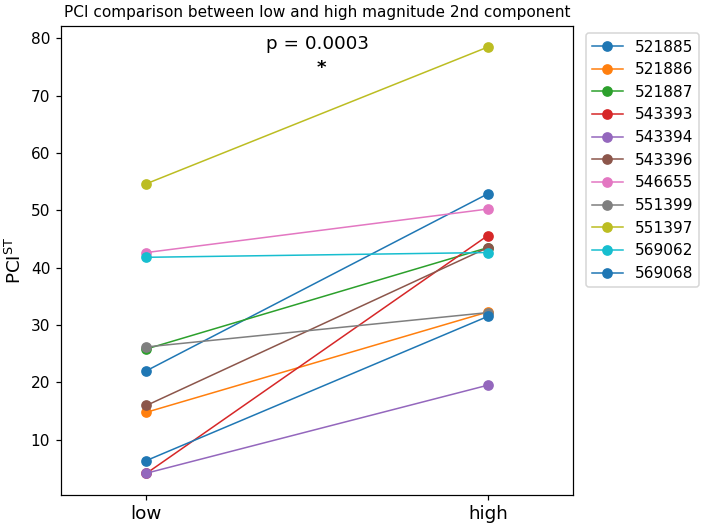

In [44]:
## Plot PCI ##
hiloPCI = pd.DataFrame(PCIvalue)
hiloPCIarray = hiloPCI.to_numpy()

# significance test #
tval, pval = stats.ttest_rel(hiloPCIarray[0,:], hiloPCIarray[1,:])

fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, hiloPCIarray.shape[0]),
    hiloPCIarray,
#     color='k',
    linewidth=1,
    marker='o',
)

if pval < 0.01:
    ax.annotate('*', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12, fontweight='bold')
ax.annotate('p = {:.4f}'.format(pval), xy=(0.5, 0.95), xycoords='axes fraction', fontsize=12, ha='center')

ax.set_xlim([-0.25, 1.25])
ax.set_xticks(np.arange(0, hiloPCIarray.shape[0]))
ax.set_xticklabels(list(hiloPCI.index), fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend(list(hiloPCI.columns), bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title('PCI comparison between low and high magnitude 2nd component')

## Save ##
figname = 'PCIforEEGmag_hi-lo_allmice.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)

<IPython.core.display.Javascript object>


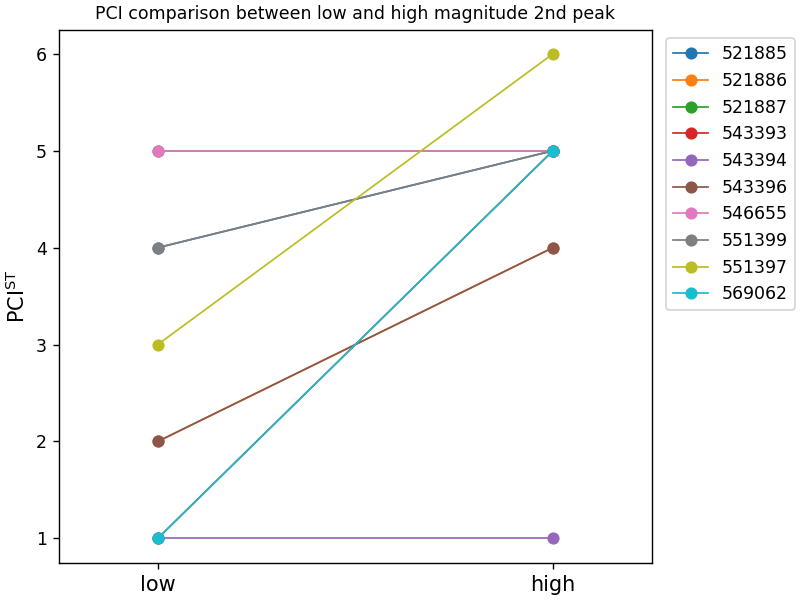

In [45]:
## Plot number of PCs ##
hiloNPCs = pd.DataFrame(nPCs)
hiloNPCsarray = hiloNPCs.to_numpy()

fig, ax = plt.subplots(constrained_layout=True)
# plot individuals with unfilled circles
individs = ax.plot(
    np.arange(0, hiloNPCsarray.shape[0]),
    hiloNPCsarray,
#     color='k',
    linewidth=1,
    marker='o',
)

ax.set_xlim([-0.25, 1.25])
ax.set_xticks(np.arange(0, hiloNPCsarray.shape[0]))
ax.set_xticklabels(list(hiloNPCs.index), fontsize=12)
ax.set_ylabel('$\mathregular{PCI^{ST}}$', fontsize=12)
ax.legend(list(hiloNPCs.columns), bbox_to_anchor=(1.01, 1), loc='upper left')
ax.set_title('PCI comparison between low and high magnitude 2nd peak')

## Save ##
figname = 'nPCsforEEGmag_hi-lo_allmice.png'
# fig.savefig(os.path.join(plotsdir, figname), transparent=True)